# NLP analysis of movie plots: preprocessing data and exploratory analysis

After collecting data we are going to run some preprocessing procedure and exploratory analysis.

## 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer

#saving data
import pickle

## 1. Loading data

In [2]:
data = pd.read_csv('data/movie_plots.csv', index_col = 'tconst', encoding = 'latin1').iloc[:,1:]
data.sample(10)

,primaryTitle,plot,averageRating
tconst,,,
tt0758766,Music and Lyrics,Alex Fletcher is a washed-up former pop star (...,6.5
tt1303902,Someone's Knocking at the Door,"Ray Harris (Jordan Lawson), a med student, sit...",4.0
tt0460505,The Rocket,The film depicts an era widely considered a co...,7.6
tt11681250,Godmothered,"In a magical place called the Motherland, fair...",6.1
tt4799050,Rough Night,"In 2006, four friends, Jess, Alice, Frankie an...",5.2
tt3136646,Soulless 2,The film tells a story of a 29-year-old top ma...,6.1
tt0203975,Tart,Cat Storm is a teenager attending an elite pre...,4.7
tt5375324,Anuraga Karikkin Vellam,"Abhilash(Abi), a young architect is in search ...",7.2
tt5053508,Rammstein in Amerika,The song deals with the worldwide cultural and...,8.1


In [3]:
data.shape

(23495, 3)

First of all, we check the number of scraped movies. 23k movies is quite good result which is 2/3 of the original list we wanted to scrape.

In [4]:
data['plot'].isna().sum()

0

We don't have missing values, but there might be some outlying instances where we scraped something different than plot.

## 2. Outliers

Outlying values can be detected by the length of the plot string. We will look into very long and very short plot descriptions.

<AxesSubplot:>

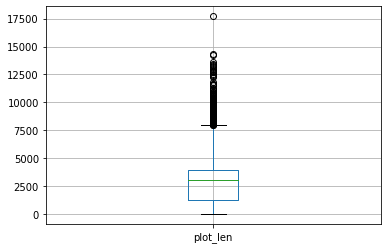

In [5]:
data['plot_len'] = data['plot'].apply(len)
data.boxplot(column = 'plot_len')

<Figure size 432x288 with 0 Axes>

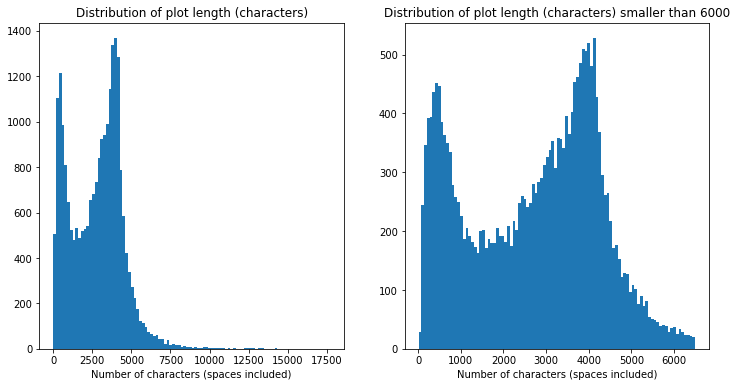

In [6]:
plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].hist(data['plot_len'], bins = 100)
ax[0].set_title('Distribution of plot length (characters)')
ax[0].set_xlabel('Number of characters (spaces included)')

ax[1].hist(data[data['plot_len'] < 6500]['plot_len'], bins = 100)
ax[1].set_title('Distribution of plot length (characters) smaller than 6000')
ax[1].set_xlabel('Number of characters (spaces included)')

plt.show()

The distribution of the `plot_len` column is not normal. We see two peaks and outliers on the right. Both plots indicate there are some large plot descriptions which we need to look into before building models

In [7]:
data[data['plot_len'] > 7500].sort_values(by = 'plot_len', ascending=False)

,primaryTitle,plot,averageRating,plot_len
tconst,,,,
tt0221344,Herod's Law,"One night, a corrupt mayor enters his office, ...",7.8,17704
tt3607198,Punjab 1984,"The film starts with a scene on 4 June 1984, d...",8.3,14320
tt15850662,The Whole Truth,Pim and Putt are teenage siblings. Pim is a po...,5.2,14277
tt3863552,Bajrangi Bhaijaan,"In the hills of Sultanpur, Jhelum, Pakistan li...",8.1,13576
tt1101665,Shaurya,Set in the context of the Insurgency in Jammu ...,7.3,13408
...,...,...,...,...
tt0107665,Needful Things,"A mysterious proprietor named Leland Gaunt, cl...",6.2,7537
tt5752192,Meander,A woman is lying in the middle of the road whe...,5.5,7535
tt1572311,Tees Maar Khan,Commissioner Khadak Singh is addressing an ass...,2.6,7529


Looks like a pretty detailed description of the movie plot, so we do not consider them as outliers. Let's also check too short descriptions

In [8]:
data.sort_values(by = 'plot_len').head(20)

,primaryTitle,plot,averageRating,plot_len
tconst,,,,
tt1871236,BlutzbrÃ¼daz,== Cast ==,6.1,10
tt0098407,Twisted Obsession,== Cast ==,5.3,10
tt4694404,Vai que Cola: O Filme,Valdomiro Lacerda moves to Leblon.,5.0,34
tt8291224,Uri: The Surgical Strike,The film is divided into five chapters.,8.2,39
tt0823451,Dus Kahaniyaan,The plot is divided into ten short stories.,5.7,43
tt9098872,The Rescue,The film follows the Tham Luang cave rescue.,8.4,44
tt0093349,King Lear,Timings are taken from the original MGM DVD.,5.4,44
tt13782428,Julia,The film chronicles the life of Julia Child.,7.6,44
tt0301777,Robot Stories,The film is divided up to four short stories:,6.0,45


We can definetly delete first 5 rows, as they do not contain any useful information

In [9]:
data = data[data['plot_len']>43]

With short plot descriptions we have danger of biasing our analysis, as short decription (basically a zero-filled row after vectorization) can become a feature itself. For example, short description as evidence of unpopular or failure movie. As the main goal of the analysis is to evaluate the importance of plot details on the movie rating, we need to remove this bias.

In [10]:
data[data['plot_len'] < 1000]['plot_len'].count()

5022

It looks like deleting short strings can cost us more than 5k instances. As some short strings contain some keywords on the plot we can clean zero-filled lines after vectorization to save as much data as possible.

## 3. Preprocessing

Running some preprocessing steps like selecting only words, not digits or punctuation, making them lowercase. We also lemmatize the words to avoid repeating the same word in different forms.

In [11]:
#remapping parts of speech for lemmatization
dict_pos_map = {
    'NN': NOUN,
    'VB':VERB,
    'JJ' : ADJ,
    'RB':ADV  
}

def Standardize(data):
    X = data.copy()
    X = X.str.replace(r"[^\w\s]", "", regex = True) #leaving only words
    X = X.str.replace('\d+', '', regex = True) #removing digits
    X = X.str.lower()
    wnl = WordNetLemmatizer()
    for i, val in enumerate(X):
        text_lem = ""
        tokens = word_tokenize(val)
        tokens_w_pos = pos_tag(tokens) #tagging words to further use lemmatizer, otherwise only considers them as nouns
        for w, pos in tokens_w_pos:
            if w in stop_words or pos not in dict_pos_map:
                continue #removing stop_words and other than noun, adj, verb, adv words
            text_lem += wnl.lemmatize(w, pos = dict_pos_map[pos])+" " #concatenating lemmatized text
        X[i] = text_lem
    return X

X = Standardize(data['plot'])
y = data['averageRating']
X[1]

'film bitter married couple ludvãâãâk senior official communist regime alcoholic wife home political party dinner home several strange disappearance spare house dead phone believe surveillance government night marriage '

Tagging part of speech helped to lemmatize words. Now we can try different types of vectorization to choose the best for our analysis.

## 4. Exploratory analysis

To choose the best model we first look at the distribution of the target value.

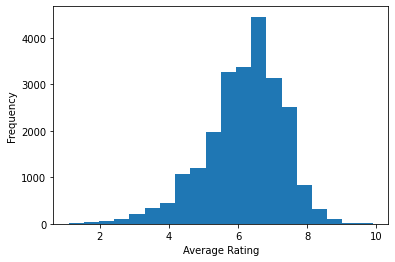

In [12]:
y = data['averageRating']

ax = y.plot(kind='hist', bins = 20)
ax.set_xlabel('Average Rating')
plt.show()

Good news - our data is almost normally distributed which is one of the assumptions for linear regression. As an option, we can also try formulating the problem as classification, but we need to take into consideration that whatever border line we choose we will face high error rate for near boarder line cases.

Now we can start vectorizing data. For our problem we believe that binary count vectorization is the best option. it does not matter how often the word or the phrase is repeated in the plot but how often it appears in different movie descriptions. For better understanding of the data we try different ngram vectorizations from 1 word to 3. We tried different values of maximum and minimum document frequencies to remove too frequent and too rare words with zero predictive power.

In [13]:
def explore_data(ngram, max_df, min_df):
    #vectorization
    vectorizer = CountVectorizer(stop_words = 'english', ngram_range = ngram, max_df = max_df, min_df = min_df, binary=True)
    X_vect = vectorizer.fit_transform(X)
    
    #plotting word frequencies
    plt.figure()
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11,12))
    
    words_in_movie = pd.DataFrame(X_vect.todense(), index=data['primaryTitle'], columns=vectorizer.get_feature_names())
    words_in_movie['count_words'] = words_in_movie.sum(axis=1)
    ax[0,1].hist(words_in_movie['count_words'], bins = min_df//5)
    ax[0,1].set_title('Movie distribution based on number of terms')
    
    movies_w_many_words = words_in_movie['count_words'].sort_values()[-20:]
    ax[0,0].barh(movies_w_many_words.index, movies_w_many_words)
    ax[0,0].set_title('Top 20 movies with largest number of terms')
    
    word_freq = pd.DataFrame(X_vect.todense().T, index=vectorizer.get_feature_names(), columns=data['primaryTitle'])
    word_freq['word_freq'] = word_freq.sum(axis=1)
    ax[1,1].hist(word_freq['word_freq'], bins = (max_df-min_df)//5)
    ax[1,1].set_title('Term frequency')
    
    frequent_words = word_freq['word_freq'].sort_values()[-20:]
    ax[1,0].barh(frequent_words.index, frequent_words)
    ax[1,0].set_title('Top 20 frequent terms')
    plt.suptitle('Plots for '+str(ngram)+'-gram vectorization with '+str(len(vectorizer.get_feature_names_out()))+' features')
    plt.show()

First, we analyze one word vectorization. We need to limit maximum frequency to cut off some common words and at the same time limit minimum frequency to remove words that are only met at few movies.

<Figure size 432x288 with 0 Axes>

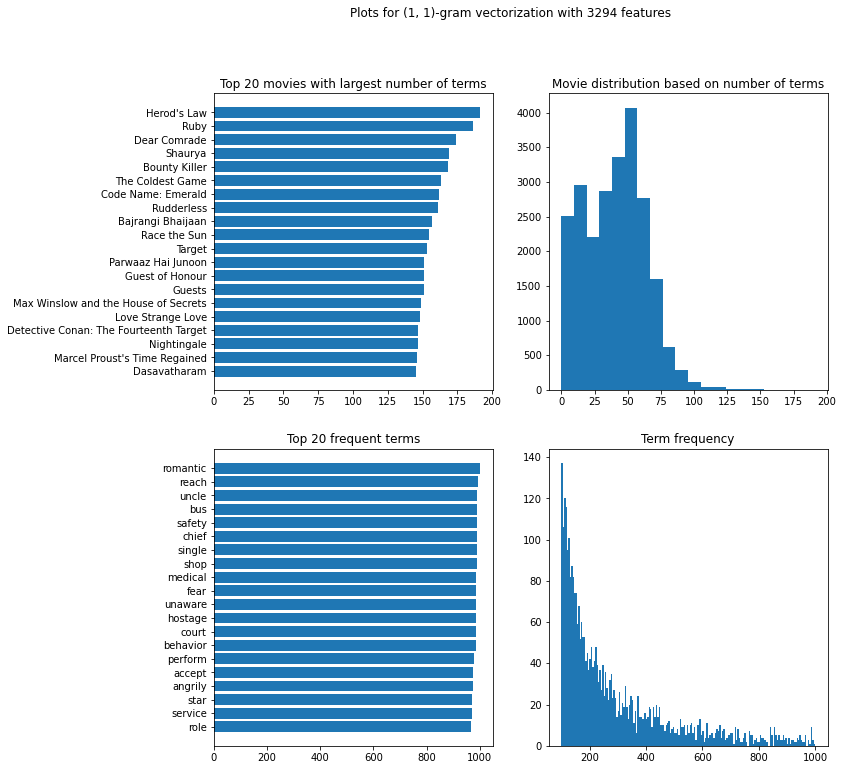

In [14]:
#one word
explore_data(ngram = (1,1), max_df = 1000, min_df = 100)

We can see that some movie plots include around 200 words from the vectorization vocabulary. In average, a movie description contains from 50 to 100 words from the determined vocabulary. Looking at the most frequent words we can hardly get any insight about the movie. Among interesting frequent words we can indicate `romantic`, `hostage`, `court` and `medical`. Probably, featurizing by two word phrases would be more useful, but we definitely reducing the document frequency of the features.

<Figure size 432x288 with 0 Axes>

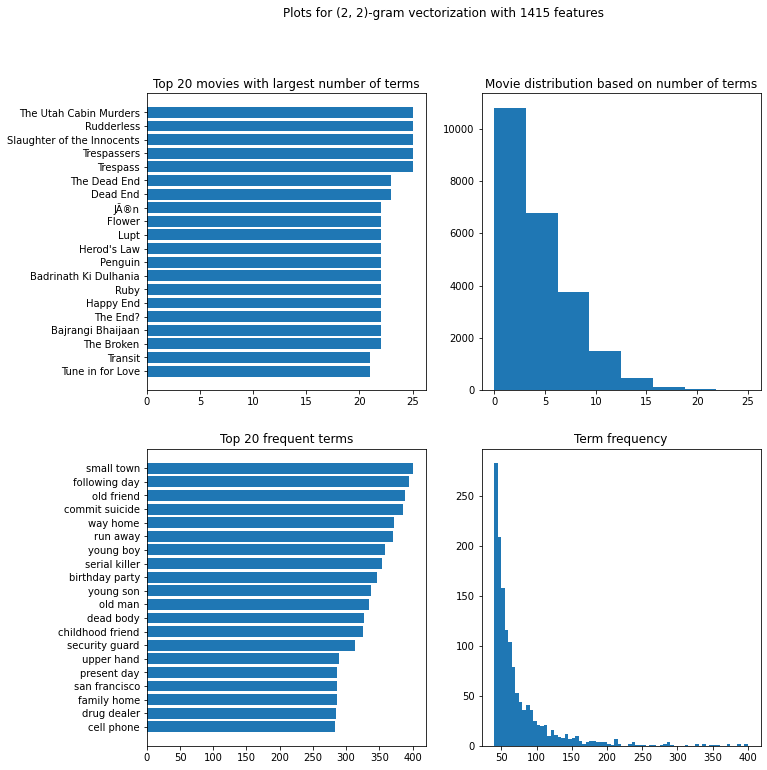

In [15]:
#two word phrases
explore_data(ngram = (2,2), max_df = 400, min_df = 40)

We reduce both document frequency parameters to get meaningful results. This time frequent terms give more information on the movie plot. For example, `serial killer` and `dead body` - probably some detectives or documention movies, or `drug dealer` - probably action movies. Oddly enough, we have `san francisco` as one of the frequent words. Let's also analyze three word phrases.

<Figure size 432x288 with 0 Axes>

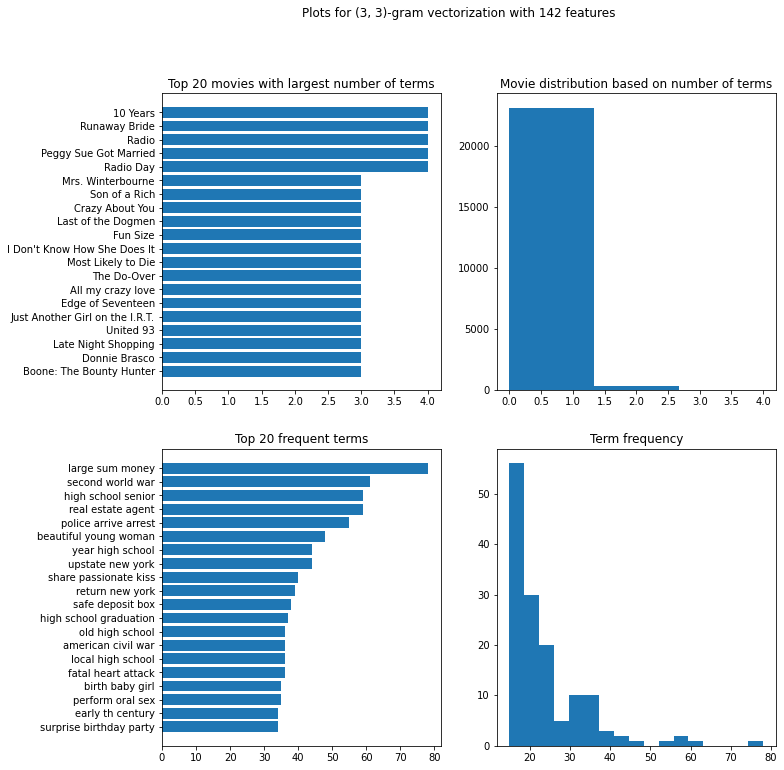

In [16]:
#three word phrases
explore_data(ngram = (3,3), max_df = 100, min_df = 15)

Three word vectorization made our data very sparse. The maximum ones we have in one row is 6. But now we have such features as `second world war`, `love first sight`, `large sum money` and so on. 

We believe the best option for further analysis is using different types of vectorization depending on the type of the model we are going to apply. For example, for regression we need independent (as much as possible) variables while for random forest we can apply (1,3) gram vectorization.

Finally, we dump cleaned data as a pickle file to use it for building models.

In [17]:
pickle.dump(X, open( "data/X.p", "wb" ))
pickle.dump(y, open( "data/y.p", "wb" ))